In [2]:
using Distributed

In [3]:
addprocs(4, exeflags="--project=$(Base.active_project())")

4-element Vector{Int64}:
 2
 3
 4
 5

In [4]:
@everywhere begin

    using PyPlot
    using Random
    using Setfield
    using Statistics
    using JLD2
    using FileIO
    using Measurements: value
    using CUDA
    using LinearAlgebra
    using ComponentArrays

    using Revise

    using CMBLensing
    using PtsrcLens
    using MPMEstimate
    
end

┌ Info: Precompiling CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317]
└ @ Base loading.jl:1317
┌ Info: Precompiling PtsrcLens [44e3c0cc-451b-45a6-9d84-ed2affe90872]
└ @ Base loading.jl:1317


In [7]:
CMBLensing.assign_GPU_workers()

┌ Info: Processes:
│  (myid = 1, host = cgpu02, device = CuDevice(0): Tesla V100-SXM2-16GB 527dbcd4))
│  (myid = 2, host = cgpu02, device = CuDevice(1): Tesla V100-SXM2-16GB 1b06131f))
│  (myid = 3, host = cgpu02, device = CuDevice(2): Tesla V100-SXM2-16GB 150ab82e))
│  (myid = 4, host = cgpu02, device = CuDevice(3): Tesla V100-SXM2-16GB e23b8ff6))
│  (myid = 5, host = cgpu02, device = CuDevice(0): Tesla V100-SXM2-16GB 527dbcd4))
└ @ CMBLensing /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/util_parallel.jl:104


# Load

In [8]:
@load "data/sehgal_maps_h5/cutouts.jld2"

5-element Vector{Symbol}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

In [9]:
@unpack (fg_noise_radio, fg_noise_ir) = get_foreground_noise(;Ms_radio, gs_radio, gs_ir);

# Configuration

In [10]:
ℓedges        = [2:100:500; round.(Int, 10 .^ range(log10(502), log10(6000), length=10))];
ℓmax_data     = 5000
polfrac_scale = 1
freq          = 90       # (90, 148)
survey        = :deep    # (:deep, :wide)
fluxcut       = 10       # (2, 5, 10, Inf)
sim           = 1;       # 1...40

# Run

In [11]:
noise_kwargs = noises[survey,freq];
fg_noise = fg_noise_radio[survey,freq,fluxcut];
M = cu(Ms_radio[survey,freq,fluxcut][sim])
nbinsϕ = length(ℓedges)-1

Cℓ = get_fiducial_Cℓ(ϕs);

@unpack ds,proj,f,ϕ = load_sim_dataset(;
    Cℓ = Cℓ,
    θpix = 2,
    storage = CuArray,    
    Nside = 300,
    pol = :P,
    bandpass_mask = LowPass(ℓmax_data),
    noise_kwargs...
);

@unpack B = ds

ds.Cϕ = Cℓ_to_Cov(:I, proj, (Cℓ.total.ϕϕ, ℓedges, :Aϕ));
ds.G = 1


Cℓg = noiseCℓs(μKarcminT=polfrac_scale*value(fg_noise)/√2, beamFWHM=0, ℓknee=0)
Cg = Cℓ_to_Cov(:P, proj, Cℓg.EE, Cℓg.BB);

In [12]:
θ₀ = ComponentArray(Aϕ=ones(Float32,nbinsϕ),)

ComponentVector{Float32}(Aϕ = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [13]:
ds_nofg = resimulate(ds, ϕ=cu(ϕs[sim]), seed=1).ds;

In [14]:
ds_withfg = @set(ds_nofg.d += polfrac_scale*B*M*cu(gs_radio[freq][sim]));

In [15]:
MAP_joint_kwargs = (progress=false, αtol=1e-4, nsteps=20);

In [16]:
rng = MersenneTwister(1)

MersenneTwister(1)

In [17]:
θmpm, σθ, history = mpm(ds_nofg, θ₀; MAP_joint_kwargs, nsteps=5, α=1, nsims=100, rng, progress=true, map=pmap);

MPM: 100%|██████████████████████████████████████████████| Time: 0:26:45m


In [18]:
θmpm′, σθ′, history′ = mpm(ds_withfg, θ₀; MAP_joint_kwargs, nsteps=5, α=1, nsims=100, rng, progress=true, map=pmap);

MPM: 100%|██████████████████████████████████████████████| Time: 0:21:39


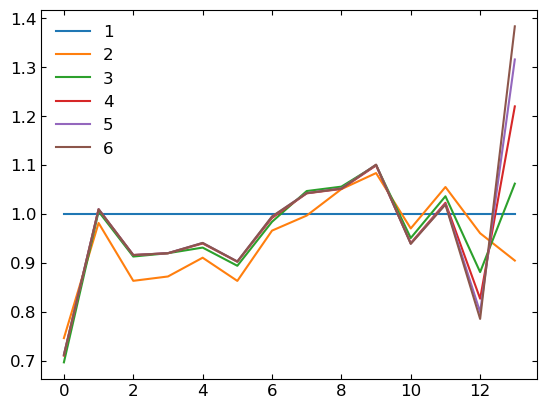

PyObject <matplotlib.legend.Legend object at 0x2aab6547a580>

In [19]:
for (i,(h,h′)) in enumerate(zip(history,history′))
    plot(h.θ, label=i)
end
# ylim(-1,0.1)
legend()

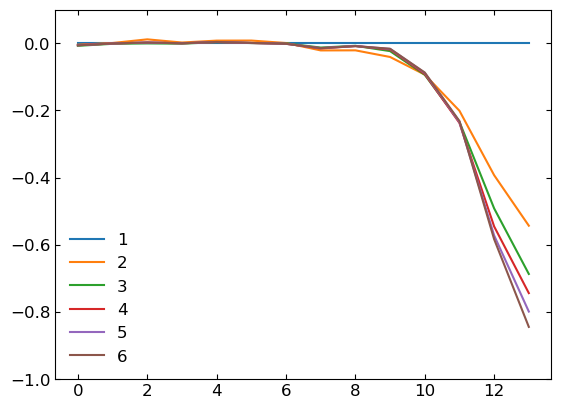

PyObject <matplotlib.legend.Legend object at 0x2aab6567f250>

In [20]:
for (i,(h,h′)) in enumerate(zip(history,history′))
    plot(h.θ-h′.θ, label=i)
end
ylim(-1,0.1)
legend()